In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from numpy import linalg as LA

def LASSO_loss(X, y, theta, lamda):
    Z = - X @ theta
    N = X.shape[0]
    t=0
    for i in range(N):
        t+= np.dot(X[i], theta[:,np.argmax(y[i])])
    return  1/N * (t + np.sum(np.log(np.sum(np.exp(Z), axis=1)))) + lamda * (LA.norm(theta))**2
#     return  1/N * (t + np.sum(np.log(np.sum(np.exp(Z), axis=1)))) 

# Define the gradient of the loss function
def full_grad_loss(X, y, theta, lamda):
    '''Return the gardient of the logistic LASSO loss at point `theta`.'''
    n = X.shape[0]
    Z = - X @ theta
    P = softmax(Z, axis=1)
    return 1/n * (X.T @ (y - P)) + 2*lamda*theta

def grad(X, y, theta, lamda, i):
    '''Return the gardient of the logistic LASSO loss at point `theta` for datam i.'''
    Z = - X[i] @ theta
    P = softmax(Z)
    X_iT= np.reshape(X[i].T,((X[i].T).shape[0],1))
    diff = y[i] - P
    diff = np.reshape(diff,(1,diff.shape[0]))
    ans= X_iT @ diff
    
    return ans+ 2*lamda*theta

def SVRG(X, y, X_test, y_test, theta, lamda, max_iter, max_iter_inner, step_size):
    n, p = X.shape
    theta_hat_history = []
    loss_history = []
    test_err=[]
    theta_history = np.zeros((max_iter_inner, theta.shape[0],theta.shape[1]))

    theta_hat = theta
    
    for t in range(max_iter):
        full_gradient = full_grad_loss(X, y, theta_hat, lamda)
        for k in range(max_iter_inner):
            i = np.random.randint(0, n)
            theta = theta - step_size * (grad(X, y, theta, lamda, i) - grad(X, y, theta_hat, lamda, i) + full_gradient)
            theta_history[k] = theta
#             print(k)
            
        theta_hat = np.mean(theta_history, axis=0)
        
        theta_hat_history.append(theta_hat)
        loss_history.append(LASSO_loss(X, y, theta_hat, lamda))
        test_err.append(1-predict(X_test,y_test, theta_hat))
        print(t, loss_history[t])
    
    return theta_hat, theta_hat_history, loss_history, test_err

def predict(x_test, y_test, theta):
    Z= -x_test @ theta
    P = softmax(Z, axis=1)
    pred = np.argmax(P, axis=1)
    corr = np.argmax(y_test, axis=1)
    acc = sum((pred==corr).astype(np.int))/y_test.shape[0]
#     print(acc)
    return acc


# Define the function to find the mod index
def find_index(t, loop_params):
    """ finds r = min{j: 0=(m mod Prod(T_l)), 0<=j<=K}
    """
    K = len(loop_params)
    T = 1.0
    for j in range(K, 0, -1):
        T1 = T * loop_params[j-1]
        if t % T == 0 and t % T1 != 0:
            return j
        T = T1
    return 0

def update_reference_points(theta_reference, theta, r):
    """ updates the reference points
    """
    updated_reference = theta_reference.copy()
    K, p, p1 = theta_reference.shape
    to_update = np.broadcast_to(theta, shape=(K - r, theta.shape[0],theta.shape[1]))
    updated_reference[r:] = to_update
    
    return updated_reference

def update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size):
    """ updates the gradients of reference points
    """
    n = X.shape[0]
    K, p, p1 = theta_reference.shape
    for l in range(r, K):
        indexes = np.arange(n)
        np.random.shuffle(indexes)
        if l == 0:
            batch_indexes = indexes[0:base_batch_size]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda)
        else:
            batch_indexes = indexes[0:batch_params[l-1]]
            gradients[l] = full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l], lamda) \
                            - full_grad_loss(X[batch_indexes], y[batch_indexes], theta_reference[l-1], lamda)
                
    return gradients

def one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size):
    assert len(loop_params) == len(batch_params), "The number of loop parameters should be the same as that of batch parameters!"
    K = len(loop_params)
    total_params = np.prod(loop_params)
    n, p = X.shape
    theta_reference = np.broadcast_to(theta, shape=(K+1, theta.shape[0],theta.shape[1]))
    theta_history = []
    
    # initialization
    gradients = np.zeros((K+1, theta.shape[0],theta.shape[1]))
    indexes = np.arange(n)
    np.random.shuffle(indexes)
    base_batch = indexes[0:base_batch_size]
    gradients[0] = full_grad_loss(X[base_batch], y[base_batch], theta, lamda)
    grad = np.sum(gradients, axis=0)
    theta = theta - 0.1 / step_size * grad
    theta_history.append(theta)
    
    # loop
    for t in range(1, total_params):
        r = find_index(t, loop_params)
        theta_reference = update_reference_points(theta_reference, theta, r)
        gradients = update_reference_gradients(X, y, gradients, theta_reference, lamda, r, batch_params, base_batch_size)
        grad = np.sum(gradients, axis=0)
        theta = theta - 0.1 / step_size * grad
        
        theta_history.append(theta)
        
    final_theta = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    final_loss = LASSO_loss(X, y, final_theta, lamda)
    
    return final_theta, theta_history[-1], final_loss

# The SNVRG algorithm, with several one_epoch_SNVRG iterations
def SNVRG(X, y, X_test, y_test, theta, lamda, max_iter, loop_params, batch_params, base_batch_size, step_size):
    theta_history = []
    loss_history = []
    test_err=[]
    for t in range(max_iter):
        theta_hat, theta, loss = one_epoch_SNVRG(X, y, theta, lamda, loop_params, batch_params, base_batch_size, step_size)
        theta_history.append(theta_hat)
        loss_history.append(loss)
        #theta_hat = theta_history[np.random.choice(len(theta_history), size=1)[0]]
        test_err.append(1-predict(X_test,y_test,theta_hat))
        print(t, loss)

    theta_hat = theta_history[np.random.choice(len(theta_history), size=1)[0]]
    return theta_hat, theta_history, loss_history, test_err

import random
def pack_batch(features, targets, dataset_size, batch_size):
    x_batch = []
    y_batch = []
    for i in range(batch_size):
        index = random.randint(0, dataset_size-1)
        x_batch.append(features[index])
        y_batch.append(targets[index])
    return np.array(x_batch), np.array(y_batch)

def SGD_mini(X,y, X_test, y_test, epochs, batch_size, theta, step_size, lamda):
    loss_history=[]
    test_err=[]
    for i in range(epochs):
        nBatches= int(X.shape[0]/batch_size)
        for j in range(nBatches):
            x_batch,y_batch = pack_batch(X,y,X.shape[0], batch_size)
            theta = theta- step_size*full_grad_loss(x_batch,y_batch,theta, lamda)
            
        test_err.append(1-predict(X_test,y_test,theta))
        loss_history.append(LASSO_loss(X, y, theta, lamda))
        print(i, loss_history[i])
    return loss_history, test_err

        
# def SGD(X,y,epochs, theta, step_size, X_test, y_test):
#     for i in range(epochs):
#         for j in range(X.shape[0]):
#             n = random.randint(0,X.shape[0]-1)
#             theta = theta- step_size*grad(X,y,theta, 0.01, n)
        
#         predict(X_test,y_test,theta)
        
def subset_idx(data, classes):
    idx=[]
    for i in range(data.shape[0]):
        if data[i] in classes:
            idx.append(i)
    return idx

def subset_classes_data(x_train, y_train, x_test, y_test, classes):
    # Subset 'plane' and 'car' classes to perform logistic regression

    idx_train = subset_idx(y_train, classes)
    idx_test = subset_idx(y_test, classes)
    
    x_train = x_train[idx_train, :]
    y_train = y_train[idx_train]

    x_test = x_test[idx_test, :]
    y_test = y_test[idx_test]
    
    return x_train, y_train, x_test, y_test




In [6]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.python.framework import ops
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = np.reshape(x_train, (x_train.shape[0], 32*32*3))
x_test = np.reshape(x_test, (x_test.shape[0], 32*32*3))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Xm=np.mean(x_train, axis=0)
# Xd =np.std(x_train, axis=0)
# Xm = np.tile(Xm, (x_train.shape[0],1))
# x_train = x_train - Xm
# x_train = x_train/Xd

# Xm=np.mean(x_test, axis=0)
# Xd =np.std(x_test, axis=0)
# Xm = np.tile(Xm, (x_test.shape[0],1))
# x_test = x_test - Xm
# x_test = x_test/Xd

x_train /= 255
x_test /= 255


classes=[i for i in range(10)]
x_train, y_train,x_test, y_test= subset_classes_data(x_train, y_train, x_test, y_test, classes)

y_train = tf.keras.utils.to_categorical(y_train, len(classes))
y_test = tf.keras.utils.to_categorical(y_test, len(classes))

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 3072)
50000 train samples
10000 test samples


In [15]:
theta = np.zeros((3072,len(classes)))
epochs= 100
svrg_theta_hat, svrg_theta_hat_history, svrg_loss_history, svrg_test_err = SVRG(x_train, y_train,x_test, y_test, theta, lamda=0.001, max_iter=epochs, 
                                                                max_iter_inner=5000, step_size=0.0025 )

<ipython-input-5-ad027029cbea>:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = sum((pred==corr).astype(np.int))/y_test.shape[0]


0 1.8497006240284652
1 1.7768830258229313
2 1.753232594974963
3 1.7395167800620783
4 1.7302454618122634
5 1.7234874882299418
6 1.7183404451295898
7 1.7142853821811515
8 1.7110025401135949
9 1.7082900796276572
10 1.7060181187850512
11 1.7040881302800155
12 1.7024323089186248
13 1.7010012200682536
14 1.6997522792016164
15 1.6986555419573564
16 1.6976860753458896
17 1.6968273318805793
18 1.6960621565898775
19 1.6953773743146643
20 1.694762919259848
21 1.6942099841113536
22 1.6937111441839476
23 1.6932599291116253
24 1.6928507465811915
25 1.6924787901885947
26 1.6921400769761767
27 1.6918311116781706
28 1.691548747307139
29 1.691290449464664
30 1.691053683250953
31 1.690836420653521
32 1.690636800278058
33 1.6904531961166505
34 1.6902841086663618
35 1.690128300794182
36 1.6899845512109786
37 1.6898517330039533
38 1.6897289993462368
39 1.689615445846863
40 1.6895103083748255
41 1.6894128748066133
42 1.6893225180235993
43 1.6892386854344206
44 1.68916088505991
45 1.689088588729473
46 1.68902

In [35]:
epochs=100
theta = np.zeros((3072,len(classes)))
# loop_params = [100,100,100,100,100,100,100,100,100,100]
loop_params= [1000]
base_batch_size = x_train.shape[0]
# batch_params = [1,1,1,1,1,1,1,1,1,1]
batch_params=[1]
step_size = 30
snvrg_theta_hat, snvrg_theta_hat_history, snvrg_loss_history, snvrg_test_err = SNVRG(x_train, y_train, x_test, y_test, theta, 0.001, epochs, loop_params, batch_params, base_batch_size, step_size)


<ipython-input-5-ad027029cbea>:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = sum((pred==corr).astype(np.int))/y_test.shape[0]


0 1.9612718552612742
1 1.881339352272619
2 1.829123410896465
3 1.8102411004796297
4 1.7903084405856664
5 1.777702845265031
6 1.767341836389423
7 1.7639473305981492
8 1.7554219717764867
9 1.7525721895227893
10 1.7493539896590193
11 1.7431053094192674
12 1.742234335836491
13 1.7384295523828088
14 1.7365381983200092
15 1.7339727531444102
16 1.7310864448830405
17 1.7289028498177663
18 1.7263435834709229
19 1.7244993080064785
20 1.7234901420560116
21 1.7217579791189002
22 1.720108047490591
23 1.7194019159916438
24 1.7185961631293933
25 1.7172240398508518
26 1.7163256460426557
27 1.7151908188509535
28 1.7137660037081086
29 1.7125766908332696
30 1.7124276664366271
31 1.7114593939545348
32 1.7101706822490155
33 1.7100196024303442
34 1.708688080834192
35 1.7080209100309947
36 1.7078080286636153
37 1.707193810633454
38 1.7066695554908604
39 1.7059043287742734
40 1.7051582039872568
41 1.704823545996866
42 1.7045206708316263
43 1.7039219088557789
44 1.7034910536106358
45 1.7030619094968982
46 1.70

In [16]:
theta = np.zeros((3072,len(classes)))
epochs=100
SGD_loss_history, SGD_test_err = SGD_mini(x_train, y_train,x_test, y_test, epochs, 1,theta, 0.0001,  0.001)


<ipython-input-5-ad027029cbea>:65: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  acc = sum((pred==corr).astype(np.int))/y_test.shape[0]


0 1.871493664089419
1 1.821167088038094
2 1.8090276668968186
3 1.7892242766598152
4 1.7766816384743052
5 1.7636294420210035
6 1.781583178436891
7 1.7553382384744307
8 1.7676633221313307
9 1.740146324343264
10 1.7493815970042903
11 1.7524480488938803
12 1.7315203491396292
13 1.7401800151837368
14 1.747218698837511
15 1.7428559599369315
16 1.739019148040398
17 1.7251660186162832
18 1.7282234946895902
19 1.7237385728947836
20 1.7188893539262442
21 1.7255242858553583
22 1.7482081491145596
23 1.7255545228119336
24 1.716873400809652
25 1.7225280359272952
26 1.7085153273833185
27 1.7223705377892025
28 1.7217553116832962
29 1.715706574614313
30 1.7140143463541213
31 1.7109669243707366
32 1.717308841788246
33 1.712466298127791
34 1.7093871867109263
35 1.7085341222595594
36 1.7118370627873258
37 1.7156730899657087
38 1.712423191597673
39 1.7064355429443587
40 1.7086090351866765
41 1.722254486956551
42 1.7028062048457377
43 1.7073751686878946
44 1.7085856890197955
45 1.7061081056251994
46 1.70644

No handles with labels found to put in legend.


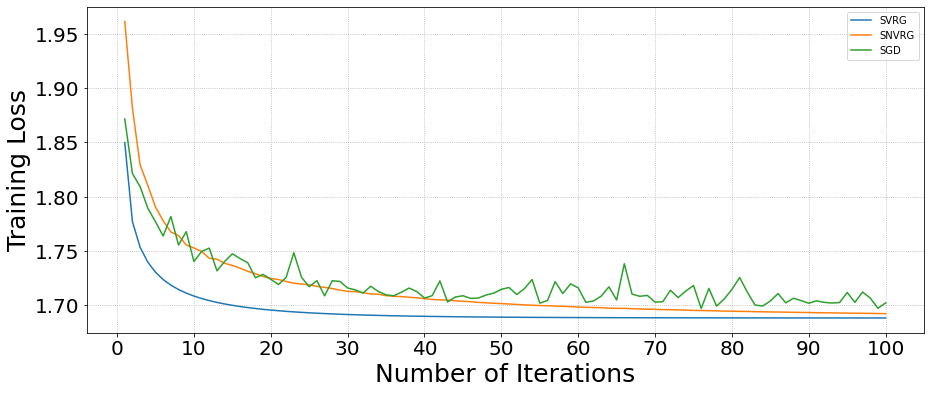

No handles with labels found to put in legend.


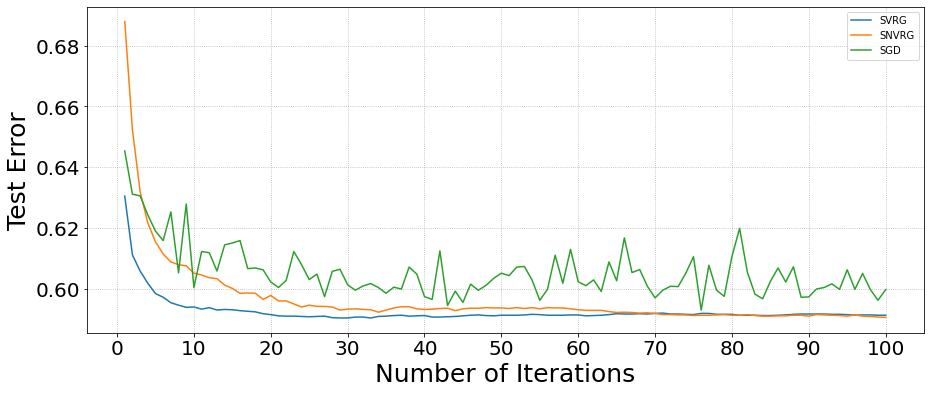

In [36]:
plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Training Loss', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), svrg_loss_history, label="SVRG")
plt.plot(np.arange(1,epochs+1,1), snvrg_loss_history,label = "SNVRG")
plt.plot(np.arange(1,epochs+1,1), SGD_loss_history,  label ="SGD")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.grid(ls=':')
plt.legend(loc='best', fontsize=25)
x_ticks=np.arange(0,epochs+1,10)
plt.xticks(x_ticks,fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Number of Iterations', fontsize=25)
plt.ylabel('Test Error', fontsize=25)
plt.plot(np.arange(1,epochs+1,1), svrg_test_err, label="SVRG")
plt.plot(np.arange(1,epochs+1,1), snvrg_test_err, label = "SNVRG")
plt.plot(np.arange(1,epochs+1,1), SGD_test_err, label = "SGD")
plt.legend()
plt.show()


In [37]:
# import numpy
# np.savetxt("svrg_loss_cifar_logist_0025.csv", svrg_loss_history, delimiter=",")
# np.savetxt("svrg_err_cifar_logist_0025.csv", svrg_test_err, delimiter=",")

# np.savetxt("SGD_loss_cifar_logist_0001.csv", SGD_loss_history, delimiter=",")
# np.savetxt("SGD_err_cifar_logist_0001.csv", SGD_test_err, delimiter=",")


# np.savetxt("snvrg_loss_cifar_logist.csv", snvrg_loss_history, delimiter=",")
# np.savetxt("snvrg_err_cifar_logist.csv", snvrg_test_err, delimiter=",")


In [57]:
snvrg_theta_hat_history

[array([[ 0.01151984, -0.01151984],
        [ 0.0110694 , -0.0110694 ],
        [ 0.01000782, -0.01000782],
        ...,
        [ 0.01182959, -0.01182959],
        [ 0.01130147, -0.01130147],
        [ 0.01052737, -0.01052737]]),
 array([[-0.00539806,  0.00539806],
        [-0.01006945,  0.01006945],
        [-0.01642522,  0.01642522],
        ...,
        [-0.0012629 ,  0.0012629 ],
        [-0.00316724,  0.00316724],
        [-0.00379816,  0.00379816]]),
 array([[-0.00669539,  0.00669539],
        [-0.01250761,  0.01250761],
        [-0.02028862,  0.02028862],
        ...,
        [-0.000173  ,  0.000173  ],
        [-0.00289222,  0.00289222],
        [-0.00426726,  0.00426726]]),
 array([[ 0.01881548, -0.01881548],
        [ 0.00940218, -0.00940218],
        [-0.00263436,  0.00263436],
        ...,
        [ 0.02084015, -0.02084015],
        [ 0.01710542, -0.01710542],
        [ 0.01600778, -0.01600778]]),
 array([[ 0.02028025, -0.02028025],
        [ 0.00931941, -0.00931941],
    

In [65]:
svrg_test_err

[0.7644,
 0.7614,
 0.7443,
 0.7686,
 0.7873,
 0.7651,
 0.7391,
 0.7537,
 0.7355,
 0.7283999999999999,
 0.7314,
 0.7186,
 0.737,
 0.7484,
 0.7137,
 0.7179,
 0.7364999999999999,
 0.7287,
 0.73,
 0.7396]

In [69]:
SGD_test_err

[0.6355,
 0.6334,
 0.6244000000000001,
 0.6362,
 0.6305000000000001,
 0.6344000000000001,
 0.6312,
 0.6484,
 0.642,
 0.6374,
 0.6333,
 0.6389,
 0.6247,
 0.6658,
 0.6408,
 0.6458999999999999,
 0.6311,
 0.6379,
 0.6425000000000001,
 0.6341]

In [13]:
svrg_test_err

[0.6332,
 0.6132,
 0.6057,
 0.6028,
 0.5978,
 0.5967,
 0.5948,
 0.5945,
 0.5937,
 0.5943,
 0.5935,
 0.5932,
 0.5935,
 0.5932999999999999,
 0.5929,
 0.5931,
 0.5932,
 0.5926,
 0.5915,
 0.5917]